_후반부에 필요한 패키지 및 함수 등 초기화_

In [1]:
from __future__ import division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import os
import time

from functools import partial

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def logit(z):
    return 1 / (1 + np.exp(-z))

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

learning_rate = 0.01

### Gradient Descent

In [3]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 300
n_hidden3 = 300
n_hidden4 = 100
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    hidden3 = my_dense_layer(hidden2, n_hidden3, name="hidden3")
    hidden4 = my_dense_layer(hidden3, n_hidden4, name="hidden4")
    hidden5 = my_dense_layer(hidden4, n_hidden5, name="hidden5")
    logits = my_dense_layer(hidden5, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) # Gradient Descent
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

![optimizer.png](./img/optimizer.png)

In [3]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

조기 종료!
Best Accuracy : 13회에서 93.040%
25.484[s]


### 11.3.3 AdaGrad

한쪽이 길쭉한 그릇 문제를 다시 생각해보면, 경사 하강법의 경우 가장 가파른 경사를 따라 빠르게 내려가기 시작해서 골짜기

아래로 느리게 이동함. 따라서 알고리즘이 이를 일찍 감지하고 전역 최적점 쪽으로 좀 더 정확한 방향을 잡았다면 좋았을 것.

**AdaGrad** 알고리즘은 가장 가파른 차원을 따라 그래디언트 벡터의 스케일을 감소시켜 이 문제를 해결함.

<br>
![eq1.png](./img/eq1.png)

첫 번째 단계는 그래디언트의 제곱을 벡터 $s$에 누적.

두 번째 단계는 경사 하강법과 거의 같지만 그래디언트 벡터를 $\sqrt{}$s+ε 으로 나누어 스케일을 조정하는 점이 다름

(ε는 0으로 나누는 것을 막기 위한 값으로, 일반적으로 $10^{-10}$).

요약하면 경사가 완만한 차원보다 가파른 차원에 대해 학습률($\eta$)을 더 빠르게 감소시킴. 이를 **적응적 학습률** 이라고 부르며, 

전역 최적점 방향으로 더 곧장 가도록 갱신되는 데 도움이 됨. 학습률 하이퍼파라미터 $\eta$를 덜 튜닝해도 되는 점이 또 하나의 장점임.


![img11_7.png](./img/img11_7.png)


AdaGrad는 간단한 2차방정식 문제에 대해서는 잘 작동하지만 신경망을 훈련시킬 때 너무 일찍 멈춰버리는 경향이 있음.

그래서 심층 신경망에는 사용하지 말아야 함(하지만 선형 회귀 같은 간단한 작업에는 효과적일 수 있음).

In [4]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 300
n_hidden3 = 300
n_hidden4 = 100
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    hidden3 = my_dense_layer(hidden2, n_hidden3, name="hidden3")
    hidden4 = my_dense_layer(hidden3, n_hidden4, name="hidden4")
    hidden5 = my_dense_layer(hidden4, n_hidden5, name="hidden5")
    logits = my_dense_layer(hidden5, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate) # AdaGrad Optimizer
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [5]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

Best Accuracy : 95회에서 95.060%
100.526[s]


### 11.3.4 RMSProp

AdaGrad는 너무 빠르게 느려져서 전역 최적점에 수렴하지 못하지만 RMSProp 알고리즘은 

(훈련 시작부터의 모든 그래디언트가 아니고) 가장 최근 반복에서 비롯된 그래디언트만 누적함으로써 이 문제를 해결했음.

<br>
![eq2.png](./img/eq2.png)

보통 감쇠율 $\beta =  0.9$ 설정함. 이 기본값이 잘 작동하는 경우가 많으므로 이를 튜닝할 필요 없음.

아주 간단한 문제를 제외하고는 이 옵티마이저가 언제나 AdaGrad보다 훨씬 더 성능이 좋음. Adam 최적화가 나오기 전까지 

연구자들이 가장 선호하는 최적화 알고리즘 이었음.

In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 300
n_hidden3 = 300
n_hidden4 = 100
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    hidden3 = my_dense_layer(hidden2, n_hidden3, name="hidden3")
    hidden4 = my_dense_layer(hidden3, n_hidden4, name="hidden4")
    hidden5 = my_dense_layer(hidden4, n_hidden5, name="hidden5")
    logits = my_dense_layer(hidden5, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"): # RMSProp Optimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [7]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

조기 종료!
Best Accuracy : 1회에서 11.260%
13.438[s]


### 11.3.5 Adam 최적화

**적응적 모멘트 추정**$^{AdaptiveMomentEstimation}$ 을 의미하는 Adam은 모멘텀 최적화와 RMSProp의 아이디어를 

합친 것.

<br>
![eq3.png](./img/eq3.png)

단계 1, 2, 5는 모멘텀 최적화, RMSProp과 아주 비슷함. 

훈련 초기에는 $m$과 $s$가 0으로 초기화 됨. 따라서 훈련 초기에 0에 치우쳐저 있기 때문에, 단계 3, 4가 훈련 초기에 $m$과 $s$의 값을 증폭시키는 데 도움을 줄 것.

보통 모멘텀 감쇠 하이퍼파라미터 $\beta_1 = 0.9$, 스케일 감쇠 하이퍼파라미터 $\beta_2 = 0.999$로 초기화함.

사실 Adam이 앞의 두 알고리즘과 같이 적응형 학습률 알고리즘이기 때문에 학습률 하이퍼파라미터 $\eta$를 튜닝할 필요가 적음(보통 0.001).

In [8]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 300
n_hidden3 = 300
n_hidden4 = 100
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    hidden3 = my_dense_layer(hidden2, n_hidden3, name="hidden3")
    hidden4 = my_dense_layer(hidden3, n_hidden4, name="hidden4")
    hidden5 = my_dense_layer(hidden4, n_hidden5, name="hidden5")
    logits = my_dense_layer(hidden5, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"): # Adam Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [9]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

조기 종료!
Best Accuracy : 21회에서 94.460%
34.636[s]


**CAUTION** 초기에 이 책은 Adam 최적화가 다른 방법보다 빠르고 좋기 때문에 이를 추천했음. 하지만 2017년에 나온 한 논문에서 적응적인 최적화 방법이 일부 데이터셋에서 나쁜 결과를 만든다는 것을 보였음. 연구자들이 이 문제에 대한 답을 찾을 때까지 지금은 모멘텀 최적화나 네스테로프 경사 가속을 사용하는 것이 나을 수 있음.




지금까지 논의한 모든 최적화 기법은 **1차 편미분(야코비안$^{Jacobian} $)** 에만 의존함.

최적화 이론에는 **2차 편미분(헤시안$^{Hessian}$)** 을 기반으로 한 뛰어난 알고리즘이 있음. 

불행히도 이런 알고리즘들은 심층 신경망에 적용하기 매우 어려움. 이런 알고리즘들은 하나의 출력마다 $n$개의 1차 편미분이 아니라 $n^{2}$개의 2차 편미분을 계산해야 하기 때문입니다($n$은 파라미터 수). 

DNN은 전형적으로 수만 개의 파라미터를 가지기 때문에 2차 편미분 최적화 알고리즘은 메모리 용량을 넘어서는 경우가 많고 가능하다고 해도 헤시안 계산은 너무 느림.

#### ___※참고 레이어 수가 줄고, 셀의 수는 그대로 일 때___

##### Gradient Descent

In [10]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 700
n_hidden2 = 350
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # Gradient Descent Optimizer
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [11]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

조기 종료!
Best Accuracy : 9회에서 90.860%
16.743[s]


##### AdaGrad

In [12]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 700
n_hidden2 = 350
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate) # AdaGrad Optimizer
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [13]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

조기 종료!
Best Accuracy : 2회에서 90.880%
11.959[s]


##### Adam

In [14]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 700
n_hidden2 = 350
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # AdamOptimizer
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [15]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

조기 종료!
Best Accuracy : 33회에서 94.560%
41.827[s]


### 11.3.6 학습률 스케줄링

학습률을 너무 크게 잡으면 훈련이 실제로 발산할 수 있음. 너무 작게 잡으면 최적점에 수렴하는 시간이 매우 오래 걸림. 

만약 조금 높게 잡으면 처음에는 매우 빠르게 진행 하겠지만 최적점 근처에서는 요동이 심해져 수렴하지 못할 수 있음.

(이는 AdaGrad, RMSProp, Adam 같은 적응적 학습률 알고리즘이 아닐 경우임. 하지만 이 알고리즘들도 안정이 되려면 시간이 걸림)

컴퓨팅 자원이 한정적이라면 차선의 솔루션을 만들기 위해 완전히 수렴하기 전에 훈련을 멈추어야 함.

![img11_8.png](./img/img11_8.png)

몇 번의 에포크만 신경망을 훈련시키고 학습 곡선을 비교해서 아주 좋은 학습률을 찾을 수 있을지도 모름.

그러나 일정한 학습률보다 더 나은 방법이 있음. 높은 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮춘다면 

최적의 고정 학습률보다 좋은 솔루션에 더 빨리 도달할 수 있음.

훈련하는 동안 학습률을 감소시키는 전략에는 여러 가지가 있음. 이런 전략을 **학습 스케줄** 이라고 함.

* **미리 정의된 개별적인 고정 학습률**  <br>
  예를 들어 처음에 $\eta_0 = 0.1$로 학습률을 지정하고 50 에포크 후에 $\eta_1 = 0.001$로 바꿈. 이 방법이 잘 작동할 수는 있지만 적절한 학습률과 적당한 시점을 찾으려면 이리저리 바꿔봐야 함.


* **성능 기반 스케줄링**  <br>
  매 $N$ 스텝마다 (조기 종료처럼) 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$ 만큼 학습률을 감소시킴.


* **지수 기반 스케줄링**  <br>
  반복 횟수 $t$의 함수 $\eta(t) = \eta_{0}10^{-t/r}$로 학습률을 설정함. 이방법이 잘 작동하지만 $\eta_0$ 와 r을 튜닝해야함. 학습률은 매 $r$ 스텝마다 1/10씩 줄어들 것. 


* **거듭제곱 기반 스케줄링**  <br>
  학습률을 $\eta(t) = \eta_0(1+t/r)^{-c}$으로 설정함. 하이퍼파라미터 $c$는 보통 1로 지정됨. 지수 기반 스케줄링과 비슷하지만 학습률이 훨씬 느리게 감소.
 

##### tf.train.cosine_decay(learning_rate, global_step, decay_steps, alpha=0.0)
global_step = min(global_step, decay_steps)<br>
cosine_decay = 0.5 $\times$ (1 + cos($\pi$ $\times$ global_step / decay_steps))<br>
decayed = (1 - alpha) $\times$ cosine_decay + alpha<br>
decayed_learning_rate = learning_rate $\times$ decayed<br>

##### tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False)
decayed_learning_rate = learning_rate $\times$ decay_rate ^ (global_step / decay_steps)

### tf.train document : https://www.tensorflow.org/api_docs/python/tf/train/

## 11.4 과대적합을 피하기 위한 규제 방법

### 11.4.1 조기 종료
훈련 세트에 과대적합되는 것을 피하기 위한 좋은 방법 하나는 조기종료임.

검증 세트의 **성능이 떨어지기 시작할 때** 훈련을 중지시키기만 하면 됨.

텐서플로로 구현하는 한 가지 방법은 일정한 간격으로(예를 들면 50 스텝마다) 검증 세트로 모델을 평가해서 이전의 

최고 성능보다 더 나을 경우 이를 최고 성능의 스냅샷으로 저장, 마지막 스냅샷이 저장된 이후 지난 스텝을 카운트해

서 이 숫자가 어떤 한계점(예를 들면 2,000스텝)을 넘으면 훈련을 중지시킴.

### 11.4.2 $\\ℓ_1$과 $\\ℓ_2$ 규제

4장에서 간단한 선형 회귀에 대해 했던 것처럼 $\\ℓ_1$과 $\\ℓ_2$ 규제를 사용해 신경망의 연결 가중치에 제약을 가할 수 있음(하지만 일반적으로 편향에는 적용하지 않습니다).

텐서플로를 사용해 이를 구현하는 한 가지 방법은 비용 함수에 적절한 규제항을 추가 하는 것.

예를 들어 가중치가 W1인 하나의 은닉층과 가중치가 W2인 출력층이 있다면 다음과 같이 $\\ℓ_1$ 규제를 적용할 수 있음.

In [16]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"): #간단한 DNN 설계
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [17]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0") # 은닉층 가중치
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0") # 출력층 가중치

scale = 0.001 # l1 규제 하이퍼파라미터
# 규제와 관련된 loss 구문
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [18]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [19]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "회 - acc:", accuracy_val)

0 회 - acc: 0.831
1 회 - acc: 0.871
2 회 - acc: 0.8838
3 회 - acc: 0.8934
4 회 - acc: 0.8966
5 회 - acc: 0.8988
6 회 - acc: 0.9016
7 회 - acc: 0.9044
8 회 - acc: 0.9058
9 회 - acc: 0.906
10 회 - acc: 0.9068
11 회 - acc: 0.9054
12 회 - acc: 0.907
13 회 - acc: 0.9084
14 회 - acc: 0.9088
15 회 - acc: 0.9064
16 회 - acc: 0.9066
17 회 - acc: 0.9066
18 회 - acc: 0.9066
19 회 - acc: 0.9052


![l1l2_1.png](./img/l1l2_1.png)

위 코드는 직접 loss 그래프 내에 l1 규제를 구현했다면, 아래 코드는 tensorflow에서 제공하는 regularizer를 사용함

In [20]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

In [21]:
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

# tf.contrib.layers.l1_l2_regularizer(scale_l1=1.0, scale_l2=1.0)
# tf.contrib.layers.l2_regularizer(scale)

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

In [22]:
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [23]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [24]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "회 - acc:", accuracy_val)

0 회 - acc: 0.8274
1 회 - acc: 0.8766
2 회 - acc: 0.8952
3 회 - acc: 0.9016
4 회 - acc: 0.9082
5 회 - acc: 0.9096
6 회 - acc: 0.9126
7 회 - acc: 0.9154
8 회 - acc: 0.9178
9 회 - acc: 0.919
10 회 - acc: 0.92
11 회 - acc: 0.9224
12 회 - acc: 0.9212
13 회 - acc: 0.9228
14 회 - acc: 0.9224
15 회 - acc: 0.9216
16 회 - acc: 0.9218
17 회 - acc: 0.9228
18 회 - acc: 0.9216
19 회 - acc: 0.9214


![l1l2_2.png](./img/l1l2_2.png)

![l1l2_3.png](./img/l1l2_3.png)

### 11.4.3 드롭아웃

심층 신경망에서 가장 인기 있는 규제 방법은 드롭아웃$^{dropdout}$(제외)임.

매 훈련 스텝에서 각 뉴런(입력 뉴런은 포함, 출력 뉴런은 제외)은 임시적으로 드롭아웃될 확률$p$를 가짐.

즉, 이번 훈련 스텝에는 완전히 무시되지만 다음 스텝에는 활성화될 수 있음.

![img11_9.png](./img/img11_9.png)

하이퍼파라미터 $p$를 드롭아웃 비율$^{DropoutRate}$이라고 하며 보통 50%로 지정함.

훈련이 끝난 후에는 뉴런에 더 이상 드롭아웃을 적용하지 않음.

In [25]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [26]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)
# 입력의 드롭아웃

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    # hidden layer 1의 드롭아웃 
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    # hidden layer 2의 드롭아웃
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [27]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

![dropout1](./img/dropout1.png)

In [28]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "회 - acc:", accuracy_val)


0 회 - acc: 0.9264
1 회 - acc: 0.9452
2 회 - acc: 0.9486
3 회 - acc: 0.9562
4 회 - acc: 0.9628
5 회 - acc: 0.9596
6 회 - acc: 0.963
7 회 - acc: 0.9672
8 회 - acc: 0.9674
9 회 - acc: 0.9702
10 회 - acc: 0.9676
11 회 - acc: 0.9706
12 회 - acc: 0.97
13 회 - acc: 0.9708
14 회 - acc: 0.972
15 회 - acc: 0.9692
16 회 - acc: 0.9724
17 회 - acc: 0.9724
18 회 - acc: 0.9724
19 회 - acc: 0.9726


### 11.4.4 맥스-노름 규제

각각의 뉴런에 대해 입력의 연결 가중치 $w$가 $ \left \| w\right \|_2 \leq  r$ 이 되도록 제한.

$r$은 맥스-노름 하이퍼파라미터이고 $ \left \| \cdot \right \|_2$는  $\\ℓ_2$ 노름을 나타냄.

일반적으로 매 훈련 스텝이 끝나고 $ \left \| w \right \|_2$ 를 계산한 다음 $w$를 클리핑($w ^{<-} w{\frac{r}{\left \| w \right \|_2}} $)함.

$r$을 줄이면 규제의 정도가 커져 과대적합을 감소시킴.

맥스-노름 규제는(배치 정규화를 사용하지 않았을 때) 그래디언트 감소/폭주 문제를 완화하는 데 도움을 줌.




In [29]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [30]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0") # 그래프에서 weights 핸들을 가져옴
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1) # clip by norm으로 클리핑하는 연산 구연
clip_weights = tf.assign(weights, clipped_weights) # weights에 clipped_weights 대입

In [31]:
# 2 번째 layer에 대한 구문
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [32]:
init = tf.global_variables_initializer()

![maxnorm1.png](./img/maxnorm1.png)
![maxnorm2.png](./img/maxnorm2.png)

In [33]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:                                  
    init.run()                                                    
    for epoch in range(n_epochs):                                      
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "회 - acc:", accuracy_val)


0 회 - acc: 0.9568
1 회 - acc: 0.9696
2 회 - acc: 0.9714
3 회 - acc: 0.9776
4 회 - acc: 0.978
5 회 - acc: 0.9786
6 회 - acc: 0.9822
7 회 - acc: 0.9814
8 회 - acc: 0.9818
9 회 - acc: 0.9826
10 회 - acc: 0.9822
11 회 - acc: 0.9852
12 회 - acc: 0.9816
13 회 - acc: 0.9838
14 회 - acc: 0.984
15 회 - acc: 0.9844
16 회 - acc: 0.9838
17 회 - acc: 0.9844
18 회 - acc: 0.9844
19 회 - acc: 0.9844


max norm의 함수화

In [34]:
# 그래프 생성 함수
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # 규제 손실을 위한 항이 없습니다
    return max_norm

In [35]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [36]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [37]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

![maxnorm3.png](./img/maxnorm3.png)
![maxnorm4.png](./img/maxnorm4.png)

In [38]:
n_epochs = 20
batch_size = 50

clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "회 - acc:", accuracy_val)                


0 회 - acc: 0.9562
1 회 - acc: 0.971
2 회 - acc: 0.9732
3 회 - acc: 0.9744
4 회 - acc: 0.975
5 회 - acc: 0.9778
6 회 - acc: 0.9798
7 회 - acc: 0.9804
8 회 - acc: 0.9816
9 회 - acc: 0.9828
10 회 - acc: 0.982
11 회 - acc: 0.9824
12 회 - acc: 0.9804
13 회 - acc: 0.982
14 회 - acc: 0.9824
15 회 - acc: 0.9812
16 회 - acc: 0.982
17 회 - acc: 0.9828
18 회 - acc: 0.982
19 회 - acc: 0.9824


### 11.4.5 데이터 증식
데이터 증식$^{DataAugmentation}$ 은 기존의 데이터에서 새로운 데이터를 생성해 인공적으로 훈련 세트의 크기를 늘림. 

→ 과대적합을 줄이므로 규제의 방도로 사용

실제와 같은 훈련 샘플 생성하는 것. 이상적으로는 사람이 인공적으로 만든 샘플인지 아닌지 구분할 수 없어야 함.

단순히 백색소음$^{WhiteNoise}$을 추가하는 것은 도움이 안 됨. 즉, 적용한 수정사항이 학습 가능한 것이어야 함.

ex) 버섯 이미지를 구분하는 모델

훈련 세트에 있는 모든 이미지를 다양하게 조금씩 이동, 회전하거나 크기를 바꿔서 만든 이미지를 훈련세트에 추가.

![img11_10.png](./img/img11_10.png)

이렇게 하면 모델이 사진에 있는 버섯의 위치, 각도, 크기에 덜 민감해짐.

빛에 대해서도 마찬가지로 명암을 달리하여 비슷하게 여러 이미지를 생성.

버섯이 대칭이라고 가정하여 이미지를 수평으로 뒤집을 수도 있음. 

이런 변환들을 결합하면 훈련 세트의 크기를 늘릴 수 있음.

훈련하는 동안 동적으로 훈련 샘플을 생성하는 것이 저장 공간이나 네트워크 대역폭 측면에서 좋음.

텐서플로는 밝기, 명암, 채도, 색조 조정은 물론

위치 변경$^{transpose}$, 이동$^{shift}$, 회전$^{rotate}$, 크기 조절$^{resize}$, 뒤집기$^{flip}$, 자르기$^{crop}$등과 같은 이미지 조작 연산을 제공(자세한 내용은 API 참고).


## 11.5 실용적 가이드라인

![table1.png](./img/table1.png)

다음과 같은 경우에는 위 기본 설정을 바꿀 필요가 있음.

* 좋은 학습률을 찾을 수 없다면 (수렴이 너무 느릴 때 학습속도를 올리면 수렴은 빨라지지만 네트워크의 정확도는 최적화가 덜 되므로) 지수 감소 같은 학습 스케줄을 추가해 볼 수 있음.


* 훈련 세트가 너무 작다면 데이터 증식을 수행할 수 있음.


* 희소 모델이 필요하면 $\\ℓ_1$규제를 추가함(또는 훈련이 끝난 뒤 작은 가중치를 0으로 만듦). 만약 더욱 희박한 희소 모델이 필요하면 네스테로프 가속 경사나 Adam 옵티마이저 대신 $\\ℓ_1$규제와 함께 FTRL 알고리즘 사용할 수 있음.


* 실행 속도가 아주 빠른 모델을 필요로 하면 배치 정규화를 빼고 ELU 활성화 함수를 LeakyReLU로 바꿈. 희소 모델을 만드는 것도 도움이 됨.

아래 코드는 앞서 5개의 레이어를 가지는 DNN에 대한 고속 옵티마이저 비교에서 사용한 그래프를 구성하고, 옵티마이저는 네스테로프 가속 경사를 사용해 학습 속도를 비교함.

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 300
n_hidden3 = 300
n_hidden4 = 100
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    hidden3 = my_dense_layer(hidden2, n_hidden3, name="hidden3")
    hidden4 = my_dense_layer(hidden3, n_hidden4, name="hidden4")
    hidden5 = my_dense_layer(hidden4, n_hidden5, name="hidden5")
    logits = my_dense_layer(hidden5, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)       
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True) 
    # Nesterov
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [12]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

조기 종료!
Best Accuracy : 26회에서 95.940%
37.965[s]


## 연습문제

### 1. He 초기화를 사용하여 무작위로 선택한 값이라면 모든 가중치를 같은 값으로 초기화해도 괜찮을까요?


* 아니오. 모든 가중치는 독립적으로 샘플링 되어야 함. 즉, 같은 초기값을 가지면 안 됨.

    가중치를 무작위로 샘플링하는 중요한 목적은 대칭성을 피하기 위함.

    모든 가중치가 0이 아니더라도 같은 초깃값을 가지면 대칭성이 깨지지 않고 역전파도 이를 해결 할 수 없음.

    구체적으로, 어떤 층에 있는 모든 뉴런이 항상 같은 가중치를 가지게 되는데, 이는 층마다 하나의 뉴런이 있는 것과 같으므로 수렴하는데 오래 걸림




### 2. 편향을 0으로 초기화해도 괜찮을까요?

   * 편향을 0으로 초기화 하는 것은 아무상관 없음. 또는 편향을 가중치처럼 초기화해도 괜찮음.

### 3. ReLU보다 ELU활성화 함수가 나은 세 가지는 무엇인가요?
   * ELU는 음수를 받을 수 있어서 뉴런의 평균 출력이 ReLU 활성화 함수보다 일반적으로 0에 더 가까움.
     이것은 그래디언트 소실 문제를 완화시켜줌. 
     

   * 도함수의 값은 항상 0이 아니기 때문에 ReLU 유닛에서 일어나는 죽은 뉴런 현상을 피할 수 있음.
   
   
   * ReLU의 기울기는 z = 0일 때 0에서 1로 급격히 바뀌는 반면, ELU는 어디에서나 도함수가 매끄럽게 바뀜. 이런 급격한 변화는 z = 0일 때 진동을 발생시키므로 경사 하강법의 속도를 느리게 만듦.
  

 <img src="./img/func_ELU.png" alt="func_ELU.png" width="480" height="360"></img>
  ![func_4.png](./img/func_4.png)
 <img src="./img/func_LReLU.png" alt="func_LReLU.png" width="480" height="360"></img>

### 4. 어떤 경우에 ELU, LeakyReLU(또는 그 변종), ReLU, tanh, logistic, softmax와 같은 활성화 함수를 사용해야 하나요?
* ELU 함수가 기본값으로 좋음. 가능한 빠른 신경망을 원한다면 대신 LeakyReLU의 변종을 사용할 수 있음(예를 들면 기본 하이퍼파라미터를 사용한 LeakyReLU). 일반적으로 ELU와 LeakyReLU의 성능이 더 뛰어남에도 ReLU 활성화 함수가 간단하기 때문에 많은 사람이 선호. 그러나 어떤 경우엔 정확히 0을 출력하는 ReLU 활성화 함수의 기능이 유용할 수 있음(15장 참조, 잡음제거 오토인코더). 소프트맥스 활성화 함수는 상호 배타적인 클래스에 대한 확률을 출력하는 출력층에 사용됨. 하지만 그 외에 은닉층에는 거의 사용되지 않음.

### 5. MomenumOptimizer를 사용할 때 momentum 하이퍼파라미터를 너무 1에 가깝게 하면 (예를 들면 0.99999) 어떤 일이 일어날까요?

* 알고리즘이 전역 최적점 방향으로 빠르게 진행되겠지만 모멘텀 때문에 최솟값을 지나치게 될 것임. 그런 다음 느려져서 되돌아오고, 다시 가속되어 또 지나치게 되는식. 이런식으로 수렴하기 전에 여러 번 진동하기 때문에 작은 momentum 값을 사용했을 때보다 전반적으로 수렴하는 데 훨씬 오래 걸릴 것.



In [9]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

learning_ratee = 0.01
momentum = 0.9 # 모멘텀
scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    logits = my_dense_layer(hidden1, n_outputs, activation=None, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [10]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "회 - acc:", accuracy_val)
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

0 회 - acc: 0.9122
1 회 - acc: 0.9258
2 회 - acc: 0.9362
3 회 - acc: 0.9432
4 회 - acc: 0.9494
5 회 - acc: 0.9518
6 회 - acc: 0.9572
7 회 - acc: 0.9584
8 회 - acc: 0.9608
9 회 - acc: 0.962
10 회 - acc: 0.9642
11 회 - acc: 0.9644
12 회 - acc: 0.9676
13 회 - acc: 0.9672
14 회 - acc: 0.9682
15 회 - acc: 0.9686
16 회 - acc: 0.9698
17 회 - acc: 0.9704
18 회 - acc: 0.972
19 회 - acc: 0.972
20 회 - acc: 0.9722
21 회 - acc: 0.9728
22 회 - acc: 0.9736
23 회 - acc: 0.9732
24 회 - acc: 0.973
25 회 - acc: 0.9752
26 회 - acc: 0.9748
27 회 - acc: 0.9742
28 회 - acc: 0.9746
29 회 - acc: 0.9748
30 회 - acc: 0.9742
31 회 - acc: 0.973
32 회 - acc: 0.9748
33 회 - acc: 0.974
34 회 - acc: 0.9748
35 회 - acc: 0.9744
36 회 - acc: 0.9744
조기 종료!
Best Accuracy : 25회에서 97.520%
18.360[s]


In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

learning_ratee = 0.01
momentum = 0.99999999 # 모멘텀
scale = 0.001

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    logits = my_dense_layer(hidden1, n_outputs, activation=None, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [8]:
n_epochs = 100
batch_size = 200

max_checks_without_progress = 10
checks_without_progress = 0
best_acc_val = 0
best_epoch = n_epochs - 1

tic = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "회 - acc:", accuracy_val)
        if accuracy_val > best_acc_val:
            best_acc_val = accuracy_val
            best_epoch = epoch
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 10회 이상 더 작으면 조기종료
                print("조기 종료!")
                break
    print(f'Best Accuracy : {best_epoch:d}회에서 {best_acc_val * 100:.3f}%')
    

toc = time.time()

print(f'{(toc - tic):.3f}[s]')

0 회 - acc: 0.8868
1 회 - acc: 0.8706
2 회 - acc: 0.8526
3 회 - acc: 0.841
4 회 - acc: 0.839
5 회 - acc: 0.8442
6 회 - acc: 0.8098
7 회 - acc: 0.768
8 회 - acc: 0.819
9 회 - acc: 0.7848
10 회 - acc: 0.7548
11 회 - acc: 0.7182
조기 종료!
Best Accuracy : 0회에서 88.680%
6.072[s]


### 6. 희소 모델을 만들 수 있는 세가지 방법은 무엇인가요?
* 희소모델(즉, 대부분의 가중치가 0인 모델)을 만드는 첫 번째 방법은 평범하게 모델을 훈련시키고 작은 가중치를 0으로 만드는 것.
두 번째 방법은 훈련하는 동안 옵티마이저에 희소한 모델을 만들도록 L1 규제를 사용하는 것.
세 번째 방법은 텐서플로의 RTROptimizer를 사용항 쌍대평균과 L1 규제를 연결하는 것.

### 7. 드롭아웃이 훈련 속도를 느리게 만드나요? 추론 inference (즉, 새로운 샘플에 대한 예측을 만드는 것)도 느리게 만드나요?

* 예. 드롭아웃은 일반적으로 대략 두 배 정도 훈련 속도를 느리게 만듬(보통 드롭아웃 비율을 0.5로 하기 때문). 그러나 드롭아웃은 훈련할 때만 적용되므로 추론에는 영향을 미치지 않음.

### 8. 딥러닝
#### a. He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요.

In [41]:
he_init = tf.variance_scaling_initializer() # He 초기화

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init): # 뉴런 100개, ELU 활성함수, He 초기화
    with tf.variable_scope(name, "dnn"): # name scope : dnn
        for layer in range(n_hidden_layers): # default 5 layers
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [42]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph() # 그래프 초기화

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X) # 그래프 생성

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

![ex8-1.png](./img/ex8-1.png)

#### b. Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요.

In [43]:
# 훈련에 필요한 구성 요소 생성

learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate) # Adam Optimizer
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1) # tf.nn.in_top_k( predictions, targets, k, name=None )
    #https://www.tensorflow.org/api_docs/python/tf/math/in_top_k
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
# 데이터 셋 준비

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [45]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

# 레이블이 5 미만인 레이블을 가지는 데이터 셋만 추출하여 사용.

In [46]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        # 학습 부분
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        # 평가 부분
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        # 새로 얻은 loss_val로 best_loss와 비교
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress: # 20회 이상 더 크면 조기종료
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.217492	최선의 손실: 0.217492	정확도: 96.01%
1	검증 세트 손실: 0.170349	최선의 손실: 0.170349	정확도: 96.52%
2	검증 세트 손실: 0.091266	최선의 손실: 0.091266	정확도: 97.58%
3	검증 세트 손실: 0.327799	최선의 손실: 0.091266	정확도: 94.25%
4	검증 세트 손실: 0.162250	최선의 손실: 0.091266	정확도: 97.11%
5	검증 세트 손실: 0.684595	최선의 손실: 0.091266	정확도: 75.84%
6	검증 세트 손실: 0.824483	최선의 손실: 0.091266	정확도: 57.43%
7	검증 세트 손실: 0.854250	최선의 손실: 0.091266	정확도: 60.95%
8	검증 세트 손실: 0.724734	최선의 손실: 0.091266	정확도: 68.22%
9	검증 세트 손실: 1.528036	최선의 손실: 0.091266	정확도: 27.52%
10	검증 세트 손실: 1.625366	최선의 손실: 0.091266	정확도: 22.01%
11	검증 세트 손실: 1.798194	최선의 손실: 0.091266	정확도: 22.01%
12	검증 세트 손실: 1.641676	최선의 손실: 0.091266	정확도: 18.73%
13	검증 세트 손실: 1.615793	최선의 손실: 0.091266	정확도: 19.27%
14	검증 세트 손실: 1.613873	최선의 손실: 0.091266	정확도: 20.91%
15	검증 세트 손실: 1.647734	최선의 손실: 0.091266	정확도: 20.91%
16	검증 세트 손실: 1.717600	최선의 손실: 0.091266	정확도: 19.08%
17	검증 세트 손실: 1.682581	최선의 손실: 0.091266	정확도: 19.27%
18	검증 세트 손실: 1.675134	최선의 손실: 0.091266	정확도: 18.73%
19	검증 세트 손실: 1.645765	최선의 손실: 0.091266	정확

![ex8-2.png](./img/ex8-2.png)

#### c. 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요.

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [47]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate: # dropout_rate가 존재하면 dropout 추가
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum: # batch_norm_momentum이 존재하면 정규화 추가
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        
        # log write ready
        graph_writer = tf.summary.FileWriter("graph_logs", self._session.graph)
        # log write close
        graph_writer.close()
        
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [48]:
# 모델 생성 및 학습
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.217492	최선의 손실: 0.217492	정확도: 96.01%
1	검증 세트 손실: 0.170349	최선의 손실: 0.170349	정확도: 96.52%
2	검증 세트 손실: 0.091266	최선의 손실: 0.091266	정확도: 97.58%
3	검증 세트 손실: 0.327799	최선의 손실: 0.091266	정확도: 94.25%
4	검증 세트 손실: 0.162250	최선의 손실: 0.091266	정확도: 97.11%
5	검증 세트 손실: 0.684595	최선의 손실: 0.091266	정확도: 75.84%
6	검증 세트 손실: 0.824483	최선의 손실: 0.091266	정확도: 57.43%
7	검증 세트 손실: 0.854250	최선의 손실: 0.091266	정확도: 60.95%
8	검증 세트 손실: 0.724734	최선의 손실: 0.091266	정확도: 68.22%
9	검증 세트 손실: 1.528036	최선의 손실: 0.091266	정확도: 27.52%
10	검증 세트 손실: 1.625366	최선의 손실: 0.091266	정확도: 22.01%
11	검증 세트 손실: 1.798194	최선의 손실: 0.091266	정확도: 22.01%
12	검증 세트 손실: 1.641676	최선의 손실: 0.091266	정확도: 18.73%
13	검증 세트 손실: 1.615793	최선의 손실: 0.091266	정확도: 19.27%
14	검증 세트 손실: 1.613873	최선의 손실: 0.091266	정확도: 20.91%
15	검증 세트 손실: 1.647734	최선의 손실: 0.091266	정확도: 20.91%
16	검증 세트 손실: 1.717600	최선의 손실: 0.091266	정확도: 19.08%
17	검증 세트 손실: 1.682581	최선의 손실: 0.091266	정확도: 19.27%
18	검증 세트 손실: 1.675134	최선의 손실: 0.091266	정확도: 18.73%
19	검증 세트 손실: 1.645765	최선의 손실: 0.091266	정확

DNNClassifier(activation=<function elu at 0x00000000192C5950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000000049EAFCC0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

![ex8-3.png](./img/ex8-3.png)

In [49]:
from sklearn.metrics import accuracy_score

# 정확도 확인 
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9787896477913991

#### class sklearn.model_selection.RandomizedSearchCV

##### _estimator : estimator object._

실제 사용할 estimator 객체로 여기서는 DNNClassifier로 만들어진 개체를 사용.

##### param_distributions : dict

교차 검증에 사용될 파라미터의 세트.

##### n_iter : int, default=10

데이터 셋에 대한 파라미터 세팅 사용 횟수. 값이 커지면 검증시간이 길어지지만 질이 좋아지며, 값이 작아지면 검증시간이 짧아지지만 질이 떨어지는 트레이트 오프 관계임.

##### random_state : int, RandomState instance or None, optional, default=None

난수 생성기의 상태, int일 경우에는 난수 생성 시드. 생성되는 난수에 따라 파라미터 세팅 순서가 바뀜.

##### cv : int, cross-validation generator or an iterable, optional

한 파라미터 세트에 대한 반복 횟수. cv 값에 따라 정확도를 출력하는 횟수가 바뀜.

##### verbose : integer

출력으로 나오는 정보를 관할, 1일경우 단순한 loss와 acc만 출력함.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

##### class DNNClassifier(BaseEstimator, ClassifierMixin):
def__init__(**self**, **n_hidden_layers**=5, **n_neurons**=100, **optimizer_class**=tf.train.AdamOptimizer, **learning_rate**=0.01, **batch_size**=20, **activation**=tf.nn.elu, **initializer**=he_init, **batch_norm_momentum**=None, **dropout_rate**=None, **random_state**=None):

In [50]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

# sklearn 매서드를 통한 교차 검증

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=10,
                                random_state=22, verbose=2, cv=5)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1} 
    # 교차검증이 행해지는 것을 보기위해 epochs는 1로 두었다.
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neurons=140, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0> 
0	검증 세트 손실: 243965.640625	최선의 손실: 243965.640625	정확도: 73.89%
[CV]  n_neurons=140, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0>, total=   7.9s
[CV] n_neurons=140, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0> 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


0	검증 세트 손실: 105751.203125	최선의 손실: 105751.203125	정확도: 94.53%
[CV]  n_neurons=140, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0>, total=   8.0s
[CV] n_neurons=140, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0> 
0	검증 세트 손실: 79280.632812	최선의 손실: 79280.632812	정확도: 78.54%
[CV]  n_neurons=140, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0>, total=   7.9s
[CV] n_neurons=140, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0> 
0	검증 세트 손실: 2447.964355	최선의 손실: 2447.964355	정확도: 94.68%
[CV]  n_neurons=140, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0>, total=   8.0s
[CV] n_neurons=140, learning_rate=0.05, batch_size=10, activa

0	검증 세트 손실: 0.116353	최선의 손실: 0.116353	정확도: 97.22%
[CV]  n_neurons=30, learning_rate=0.02, batch_size=50, activation=<function relu at 0x00000000192D3C80>, total=   1.7s
[CV] n_neurons=30, learning_rate=0.02, batch_size=50, activation=<function relu at 0x00000000192D3C80> 
0	검증 세트 손실: 0.129267	최선의 손실: 0.129267	정확도: 97.15%
[CV]  n_neurons=30, learning_rate=0.02, batch_size=50, activation=<function relu at 0x00000000192D3C80>, total=   1.7s
[CV] n_neurons=100, learning_rate=0.02, batch_size=10, activation=<function elu at 0x00000000192C5950> 
0	검증 세트 손실: 1.712075	최선의 손실: 1.712075	정확도: 19.08%
[CV]  n_neurons=100, learning_rate=0.02, batch_size=10, activation=<function elu at 0x00000000192C5950>, total=   6.4s
[CV] n_neurons=100, learning_rate=0.02, batch_size=10, activation=<function elu at 0x00000000192C5950> 
0	검증 세트 손실: 1.717215	최선의 손실: 1.717215	정확도: 19.08%
[CV]  n_neurons=100, learning_rate=0.02, batch_size=10, activation=<function elu at 0x00000000192C5950>, total=   6.4s
[CV] n_neuro

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.7min finished


0	검증 세트 손실: 0.103159	최선의 손실: 0.103159	정확도: 97.42%


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x00000000192C5950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000000049EAFCC0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x00000000192D3C80>, <function elu at 0x00000000192C5950>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000006776AE8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000022C762F0>]},
          pre_dispatch='2*n_jobs', random_state=22, refit=True,
      

In [51]:
# 최적의 파라미터 세팅 확인
rnd_search.best_params_

{'n_neurons': 30,
 'learning_rate': 0.02,
 'batch_size': 50,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [52]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9747032496594669

#### d. 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?

In [53]:
def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

In [54]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.072004	최선의 손실: 0.072004	정확도: 97.77%
1	검증 세트 손실: 0.058453	최선의 손실: 0.058453	정확도: 98.28%
2	검증 세트 손실: 0.040213	최선의 손실: 0.040213	정확도: 98.71%
3	검증 세트 손실: 0.048657	최선의 손실: 0.040213	정확도: 98.63%
4	검증 세트 손실: 0.050188	최선의 손실: 0.040213	정확도: 98.55%
5	검증 세트 손실: 0.035519	최선의 손실: 0.035519	정확도: 98.91%
6	검증 세트 손실: 0.048708	최선의 손실: 0.035519	정확도: 98.67%
7	검증 세트 손실: 0.034432	최선의 손실: 0.034432	정확도: 99.10%
8	검증 세트 손실: 0.071947	최선의 손실: 0.034432	정확도: 98.71%
9	검증 세트 손실: 0.046487	최선의 손실: 0.034432	정확도: 98.67%
10	검증 세트 손실: 0.061813	최선의 손실: 0.034432	정확도: 98.91%
11	검증 세트 손실: 0.058360	최선의 손실: 0.034432	정확도: 98.71%
12	검증 세트 손실: 0.051923	최선의 손실: 0.034432	정확도: 98.87%
13	검증 세트 손실: 0.064132	최선의 손실: 0.034432	정확도: 98.59%
14	검증 세트 손실: 0.060787	최선의 손실: 0.034432	정확도: 98.79%
15	검증 세트 손실: 0.049941	최선의 손실: 0.034432	정확도: 98.94%
16	검증 세트 손실: 0.064815	최선의 손실: 0.034432	정확도: 98.91%
17	검증 세트 손실: 0.049389	최선의 손실: 0.034432	정확도: 98.94%
18	검증 세트 손실: 0.076514	최선의 손실: 0.034432	정확도: 98.67%
19	검증 세트 손실: 0.049628	최선의 손실: 0.034432	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000005433D90>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000000049EAFCC0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

![ex8-4.png](./img/ex8-4.png)

In [55]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9904650710254913

In [56]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.046399	최선의 손실: 0.046399	정확도: 98.71%
1	검증 세트 손실: 0.057514	최선의 손실: 0.046399	정확도: 98.05%
2	검증 세트 손실: 0.046561	최선의 손실: 0.046399	정확도: 98.63%
3	검증 세트 손실: 0.044289	최선의 손실: 0.044289	정확도: 98.71%
4	검증 세트 손실: 0.044379	최선의 손실: 0.044289	정확도: 98.75%
5	검증 세트 손실: 0.054216	최선의 손실: 0.044289	정확도: 98.59%
6	검증 세트 손실: 0.038474	최선의 손실: 0.038474	정확도: 99.10%
7	검증 세트 손실: 0.031520	최선의 손실: 0.031520	정확도: 99.18%
8	검증 세트 손실: 0.039194	최선의 손실: 0.031520	정확도: 98.94%
9	검증 세트 손실: 0.040424	최선의 손실: 0.031520	정확도: 99.18%
10	검증 세트 손실: 0.034827	최선의 손실: 0.031520	정확도: 99.14%
11	검증 세트 손실: 0.037619	최선의 손실: 0.031520	정확도: 99.02%
12	검증 세트 손실: 0.031217	최선의 손실: 0.031217	정확도: 99.30%
13	검증 세트 손실: 0.045529	최선의 손실: 0.031217	정확도: 98.79%
14	검증 세트 손실: 0.043039	최선의 손실: 0.031217	정확도: 99.02%
15	검증 세트 손실: 0.044173	최선의 손실: 0.031217	정확도: 98.98%
16	검증 세트 손실: 0.052172	최선의 손실: 0.031217	정확도: 98.87%
17	검증 세트 손실: 0.047888	최선의 손실: 0.031217	정확도: 98.87%
18	검증 세트 손실: 0.041204	최선의 손실: 0.031217	정확도: 98.94%
19	검증 세트 손실: 0.035944	최선의 손실: 0.031217	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x0000000005449D08>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000000049EAFCC0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

![ex8-5.png](./img/ex8-5.png)

In [57]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9947460595446584

In [58]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=10,
                                   random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x00000000192C5950> 
0	검증 세트 손실: 0.205692	최선의 손실: 0.205692	정확도: 94.14%
[CV]  n_neurons=100, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x00000000192C5950>, total=   2.5s
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x00000000192C5950> 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


0	검증 세트 손실: 0.213113	최선의 손실: 0.213113	정확도: 93.94%
[CV]  n_neurons=100, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x00000000192C5950>, total=   2.5s
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x00000000192C5950> 
0	검증 세트 손실: 0.158706	최선의 손실: 0.158706	정확도: 94.61%
[CV]  n_neurons=100, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x00000000192C5950>, total=   2.5s
[CV] n_neurons=140, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x00000000192C5950> 
0	검증 세트 손실: 13.416183	최선의 손실: 13.416183	정확도: 66.93%
[CV]  n_neurons=140, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x00000000192C5950>, total=   2.5s
[CV] n_neurons=140, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x00000000192C5950> 
0	검증 세트 손실: 4.886566	최선의 손

0	검증 세트 손실: 0.101827	최선의 손실: 0.101827	정확도: 97.07%
[CV]  n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.98, activation=<function relu at 0x00000000192D3C80>, total=   5.9s
[CV] n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.98, activation=<function relu at 0x00000000192D3C80> 
0	검증 세트 손실: 0.100589	최선의 손실: 0.100589	정확도: 97.11%
[CV]  n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.98, activation=<function relu at 0x00000000192D3C80>, total=   5.9s
[CV] n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000003295A8C8> 
0	검증 세트 손실: 0.062582	최선의 손실: 0.062582	정확도: 98.16%
[CV]  n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000003295A8C8>, total=   6.3s
[CV] n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.8min finished


0	검증 세트 손실: 0.088415	최선의 손실: 0.088415	정확도: 97.34%


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x00000000192C5950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000000049EAFCC0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x00000000192D3C80>, <function elu at 0x00000000192C5950>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000003295A8C8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000003295AE18>], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_d

In [59]:
rnd_search_bn.best_params_

{'n_neurons': 120,
 'learning_rate': 0.01,
 'batch_size': 50,
 'batch_norm_momentum': 0.9,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [60]:
# 테스트 셋에 대한 정확도
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9747032496594669

#### e. 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해보세요. 도움이 되었나요?

In [61]:
# 트레이닝 셋에 대한 정확도
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9975390541408089

In [62]:
# 드롭아웃이 활성화된 DNN 모델
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.132892	최선의 손실: 0.132892	정확도: 96.64%
1	검증 세트 손실: 0.106895	최선의 손실: 0.106895	정확도: 97.30%
2	검증 세트 손실: 0.090244	최선의 손실: 0.090244	정확도: 97.69%
3	검증 세트 손실: 0.082031	최선의 손실: 0.082031	정확도: 97.77%
4	검증 세트 손실: 0.093091	최선의 손실: 0.082031	정확도: 97.89%
5	검증 세트 손실: 0.085899	최선의 손실: 0.082031	정확도: 97.93%
6	검증 세트 손실: 0.073079	최선의 손실: 0.073079	정확도: 97.85%
7	검증 세트 손실: 0.077855	최선의 손실: 0.073079	정확도: 98.16%
8	검증 세트 손실: 0.070201	최선의 손실: 0.070201	정확도: 98.01%
9	검증 세트 손실: 0.072985	최선의 손실: 0.070201	정확도: 98.01%
10	검증 세트 손실: 0.068381	최선의 손실: 0.068381	정확도: 98.12%
11	검증 세트 손실: 0.069045	최선의 손실: 0.068381	정확도: 98.28%
12	검증 세트 손실: 0.082291	최선의 손실: 0.068381	정확도: 97.97%
13	검증 세트 손실: 0.068411	최선의 손실: 0.068381	정확도: 98.12%
14	검증 세트 손실: 0.070232	최선의 손실: 0.068381	정확도: 98.28%
15	검증 세트 손실: 0.071348	최선의 손실: 0.068381	정확도: 98.24%
16	검증 세트 손실: 0.068500	최선의 손실: 0.068381	정확도: 98.05%
17	검증 세트 손실: 0.065135	최선의 손실: 0.065135	정확도: 98.40%
18	검증 세트 손실: 0.066330	최선의 손실: 0.065135	정확도: 98.40%
19	검증 세트 손실: 0.066908	최선의 손실: 0.065135	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000000365A21E0>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000000049EAFCC0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

![ex8-6.png](./img/ex8-6.png)

In [63]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.986573263280794

### 9. 전이 학습

#### a. 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요.

In [64]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [65]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [66]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

![ex9-1.png](./img/ex9-1.png)

#### b. 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [67]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

# 5이상의 값을 가지는 레이블을 얻어온 후 레이블에 5를 빼서 0~4까지의 레이블이 되도록 조작.

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [68]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [69]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [70]:
# 트레이닝

import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.275385	최선의 손실: 1.275385	정확도: 50.67%
1	검증 세트 손실: 1.214228	최선의 손실: 1.214228	정확도: 50.67%
2	검증 세트 손실: 1.122662	최선의 손실: 1.122662	정확도: 50.67%
3	검증 세트 손실: 1.103540	최선의 손실: 1.103540	정확도: 52.00%
4	검증 세트 손실: 1.088736	최선의 손실: 1.088736	정확도: 53.33%
5	검증 세트 손실: 1.057204	최선의 손실: 1.057204	정확도: 56.67%
6	검증 세트 손실: 1.049103	최선의 손실: 1.049103	정확도: 57.33%
7	검증 세트 손실: 1.048192	최선의 손실: 1.048192	정확도: 58.00%
8	검증 세트 손실: 1.023718	최선의 손실: 1.023718	정확도: 58.00%
9	검증 세트 손실: 1.022433	최선의 손실: 1.022433	정확도: 56.00%
10	검증 세트 손실: 1.027909	최선의 손실: 1.022433	정확도: 60.67%
11	검증 세트 손실: 1.103764	최선의 손실: 1.022433	정확도: 56.00%
12	검증 세트 손실: 1.086111	최선의 손실: 1.022433	정확도: 54.67%
13	검증 세트 손실: 1.028749	최선의 손실: 1.022433	정확도: 57.33%
14	검증 세트 손실: 1.072682	최선의 손실: 1.022433	정확도: 58.67%
15	검증 세트 손실: 1.025460	최선의 손실: 1.022433	정확도: 62.00%
16	검증 세트 손실: 0.966505	최선의 손실: 0.966505	정확도: 63.33%
17	검증 세트 손실: 1.015548	최선의 손실: 0.966505	정확도: 58.00%
18	검증 세트 손실: 0.978822

#### c. 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?

In [71]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다)

In [72]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

# log write ready
graph_writer = tf.summary.FileWriter("graph_logs", tf.Session().graph)
# log write close
graph_writer.close()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.333802	최선의 손실: 1.333802	정확도: 47.33%
1	검증 세트 손실: 1.200852	최선의 손실: 1.200852	정확도: 50.00%
2	검증 세트 손실: 1.146627	최선의 손실: 1.146627	정확도: 58.00%
3	검증 세트 손실: 1.089491	최선의 손실: 1.089491	정확도: 54.67%
4	검증 세트 손실: 1.084895	최선의 손실: 1.084895	정확도: 52.00%
5	검증 세트 손실: 1.081458	최선의 손실: 1.081458	정확도: 52.00%
6	검증 세트 손실: 1.027767	최선의 손실: 1.027767	정확도: 56.00%
7	검증 세트 손실: 1.057860	최선의 손실: 1.027767	정확도: 56.67%
8	검증 세트 손실: 1.004813	최선의 손실: 1.004813	정확도: 60.00%
9	검증 세트 손실: 1.156362	최선의 손실: 1.004813	정확도: 51.33%
10	검증 세트 손실: 1.066781	최선의 손실: 1.004813	정확도: 55.33%
11	검증 세트 손실: 1.086581	최선의 손실: 1.004813	정확도: 59.33%
12	검증 세트 손실: 0.991869	최선의 손실: 0.991869	정확도: 59.33%
13	검증 세트 손실: 1.039530	최선의 손실: 0.991869	정확도: 61.33%
14	검증 세트 손실: 1.019834	최선의 손실: 0.991869	정확도: 60.00%
15	검증 세트 손실: 1.009118	최선의 손실: 0.991869	정확도: 60.67%
16	검증 세트 손실: 1.191170	최선의 손실: 0.991869	정확도: 54.67%
17	검증 세트 손실: 1.088326	최선의 손실: 0.991869	정확도: 62.67%
18	검증 세트 손실: 0.998450

#### d. 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?

In [73]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits") 
# 4번째 출력에서 output이 되는 tf.layers.dense() 생성
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [74]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
#new_logits만 학습에 사용
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [75]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.139616	최선의 손실: 1.139616	정확도: 50.00%
1	검증 세트 손실: 1.185013	최선의 손실: 1.139616	정확도: 52.67%
2	검증 세트 손실: 1.099084	최선의 손실: 1.099084	정확도: 50.00%
3	검증 세트 손실: 1.048637	최선의 손실: 1.048637	정확도: 54.00%
4	검증 세트 손실: 1.054338	최선의 손실: 1.048637	정확도: 58.00%
5	검증 세트 손실: 1.017123	최선의 손실: 1.017123	정확도: 60.67%
6	검증 세트 손실: 0.984236	최선의 손실: 0.984236	정확도: 62.67%
7	검증 세트 손실: 0.983788	최선의 손실: 0.983788	정확도: 63.33%
8	검증 세트 손실: 0.950740	최선의 손실: 0.950740	정확도: 63.33%
9	검증 세트 손실: 0.958342	최선의 손실: 0.950740	정확도: 63.33%
10	검증 세트 손실: 0.952328	최선의 손실: 0.950740	정확도: 64.00%
11	검증 세트 손실: 1.025500	최선의 손실: 0.950740	정확도: 62.00%
12	검증 세트 손실: 0.958744	최선의 손실: 0.950740	정확도: 64.67%
13	검증 세트 손실: 0.917655	최선의 손실: 0.917655	정확도: 66.67%
14	검증 세트 손실: 0.957702	최선의 손실: 0.917655	정확도: 61.33%
15	검증 세트 손실: 0.924674	최선의 손실: 0.917655	정확도: 64.00%
16	검증 세트 손실: 0.920495	최선의 손실: 0.917655	정확도: 66.00%
17	검증 세트 손실: 0.892814	최선의 손실: 0.892814	정확도: 66.00%
18	검증 세트 손실: 0.872195

![ex9-2.png](./img/ex9-2.png)

#### e. 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?

In [76]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [77]:
# 재훈련

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 1.105117	최선의 손실: 1.105117	정확도: 69.33%
1	검증 세트 손실: 1.158623	최선의 손실: 1.105117	정확도: 72.00%
2	검증 세트 손실: 0.755095	최선의 손실: 0.755095	정확도: 78.67%
3	검증 세트 손실: 0.876163	최선의 손실: 0.755095	정확도: 80.00%
4	검증 세트 손실: 1.087565	최선의 손실: 0.755095	정확도: 73.33%
5	검증 세트 손실: 1.029427	최선의 손실: 0.755095	정확도: 75.33%
6	검증 세트 손실: 1.043349	최선의 손실: 0.755095	정확도: 77.33%
7	검증 세트 손실: 1.450104	최선의 손실: 0.755095	정확도: 80.00%
8	검증 세트 손실: 1.433299	최선의 손실: 0.755095	정확도: 77.33%
9	검증 세트 손실: 1.574803	최선의 손실: 0.755095	정확도: 75.33%
10	검증 세트 손실: 1.492265	최선의 손실: 0.755095	정확도: 82.00%
11	검증 세트 손실: 1.585494	최선의 손실: 0.755095	정확도: 80.00%
12	검증 세트 손실: 1.003593	최선의 손실: 0.755095	정확도: 80.67%
13	검증 세트 손실: 1.486751	최선의 손실: 0.755095	정확도: 77.33%
14	검증 세트 손실: 1.418568	최선의 손실: 0.755095	정확도: 82.00%
15	검증 세트 손실: 1.157110	최선의 손실: 0.755095	정확도: 81.33%
16	검증 세트 손실: 1.362491	최선의 손실: 0.755095	정확도: 80.00%
17	검증 세트 손실: 1.362268	최선의 손실: 0.755095	정확도: 78.00%
18	검증 세트 손실: 1

![ex9-3.png](./img/ex9-3.png)

In [78]:
# 전체 재 훈련을 위해
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [79]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 0.915181	최선의 손실: 0.915181	정확도: 76.67%
1	검증 세트 손실: 0.532479	최선의 손실: 0.532479	정확도: 84.00%
2	검증 세트 손실: 0.407154	최선의 손실: 0.407154	정확도: 90.67%
3	검증 세트 손실: 0.480797	최선의 손실: 0.407154	정확도: 88.00%
4	검증 세트 손실: 0.312727	최선의 손실: 0.312727	정확도: 90.67%
5	검증 세트 손실: 0.572035	최선의 손실: 0.312727	정확도: 92.67%
6	검증 세트 손실: 0.285512	최선의 손실: 0.285512	정확도: 92.00%
7	검증 세트 손실: 0.320394	최선의 손실: 0.285512	정확도: 92.67%
8	검증 세트 손실: 0.550538	최선의 손실: 0.285512	정확도: 90.00%
9	검증 세트 손실: 0.558102	최선의 손실: 0.285512	정확도: 91.33%
10	검증 세트 손실: 0.568721	최선의 손실: 0.285512	정확도: 90.67%
11	검증 세트 손실: 0.610730	최선의 손실: 0.285512	정확도: 90.00%
12	검증 세트 손실: 0.543822	최선의 손실: 0.285512	정확도: 92.67%
13	검증 세트 손실: 0.557883	최선의 손실: 0.285512	정확도: 92.67%
14	검증 세트 손실: 0.867094	최선의 손실: 0.285512	정확도: 85.33%
15	검증 세트 손실: 0.771359	최선의 손실: 0.285512	정확도: 88.00%
16	검증 세트 손실: 1.002985	최선의 손실: 0.285512	정확도: 84.67%
17	검증 세트 손실: 0.467146	최선의 손실: 0.285512	정확도: 91.33%
18	검증 세트 손실: 0.

![ex9-4.png](./img/ex9-4.png)

In [80]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.674593	최선의 손실: 0.674593	정확도: 80.67%
1	검증 세트 손실: 0.584863	최선의 손실: 0.584863	정확도: 88.67%
2	검증 세트 손실: 0.647398	최선의 손실: 0.584863	정확도: 84.00%
3	검증 세트 손실: 0.530267	최선의 손실: 0.530267	정확도: 87.33%
4	검증 세트 손실: 0.685232	최선의 손실: 0.530267	정확도: 90.00%
5	검증 세트 손실: 0.528450	최선의 손실: 0.528450	정확도: 89.33%
6	검증 세트 손실: 0.787493	최선의 손실: 0.528450	정확도: 89.33%
7	검증 세트 손실: 0.688933	최선의 손실: 0.528450	정확도: 88.00%
8	검증 세트 손실: 0.635708	최선의 손실: 0.528450	정확도: 87.33%
9	검증 세트 손실: 0.457762	최선의 손실: 0.457762	정확도: 93.33%
10	검증 세트 손실: 0.706879	최선의 손실: 0.457762	정확도: 87.33%
11	검증 세트 손실: 1.013173	최선의 손실: 0.457762	정확도: 88.00%
12	검증 세트 손실: 1.054063	최선의 손실: 0.457762	정확도: 85.33%
13	검증 세트 손실: 0.755688	최선의 손실: 0.457762	정확도: 89.33%
14	검증 세트 손실: 0.779543	최선의 손실: 0.457762	정확도: 92.00%
15	검증 세트 손실: 1.277703	최선의 손실: 0.457762	정확도: 89.33%
16	검증 세트 손실: 0.977737	최선의 손실: 0.457762	정확도: 86.67%
17	검증 세트 손실: 0.576649	최선의 손실: 0.457762	정확도: 90.67%
18	검증 세트 손실: 0.890895	최선의 손실: 0.457762	정확도: 89.33%
19	검증 세트 손실: 0.827233	최선의 손실: 0.457762	정확

DNNClassifier(activation=<function elu at 0x00000000192C5950>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x0000000049EAFCC0>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [81]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8813001440032915

![ex9-5.png](./img/ex9-5.png)

### 10. 보조 작업으로 사전훈련

#### a. 이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다. 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서 만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그 다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 concat() 함수를 axis=1로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다.

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [82]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1) # 하나의 플레이스 홀더를 두개의 텐서로 나누는 구문

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [83]:
y = tf.placeholder(tf.int32, shape=[None, 1])

In [84]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B") 

dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

In [85]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

In [86]:
# dnn 출력에 새로운 출력
# logits에는 hidden의 출력이 1개의 뉴런으로 들어감.
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [87]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [88]:
# loss
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

# optimizer
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

# acc
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [89]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

![ex10-1.png](./img/ex10-1.png)

#### b. MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다.

In [90]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [91]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [92]:
# batch size 5개로 테스트 
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [93]:
X_batch.shape
# batch_size : 5, DNN 쌍 : 2, 28*28 : 784

(5, 2, 784)

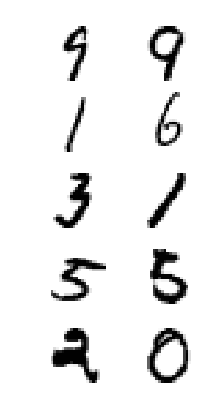

In [94]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [95]:
# 서로 다른 수는 0, 같은 수는 1
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

#### c. 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다.

In [96]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [97]:
X_test.shape, X_test1.shape
# batch_size : 10000, DNN 쌍 : 2, 28*28 : 784

((10000, 784), (10000, 2, 784))

In [98]:
n_epochs = 100
batch_size = 500

# log write ready
graph_writer = tf.summary.FileWriter("graph_logs", tf.Session().graph)
# log write close
graph_writer.close()


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.6910327
0 테스트 정확도: 0.542
1 훈련 손실: 0.60353535
2 훈련 손실: 0.54946035
3 훈련 손실: 0.47047246
4 훈련 손실: 0.4060757
5 훈련 손실: 0.38308153
5 테스트 정확도: 0.824
6 훈련 손실: 0.39047274
7 훈련 손실: 0.33907944
8 훈련 손실: 0.32106704
9 훈련 손실: 0.31792682
10 훈련 손실: 0.2449429
10 테스트 정확도: 0.8881
11 훈련 손실: 0.2929237
12 훈련 손실: 0.2322544
13 훈련 손실: 0.23180936
14 훈련 손실: 0.19877945
15 훈련 손실: 0.20065445
15 테스트 정확도: 0.9203
16 훈련 손실: 0.19700487
17 훈련 손실: 0.18893173
18 훈련 손실: 0.19965445
19 훈련 손실: 0.24071614
20 훈련 손실: 0.18882047
20 테스트 정확도: 0.9367
21 훈련 손실: 0.12419216
22 훈련 손실: 0.14013438
23 훈련 손실: 0.1207896
24 훈련 손실: 0.15721174
25 훈련 손실: 0.11507863
25 테스트 정확도: 0.948
26 훈련 손실: 0.1389112
27 훈련 손실: 0.15260854
28 훈련 손실: 0.12343663
29 훈련 손실: 0.11543138
30 훈련 손실: 0.1140279
30 테스트 정확도: 0.9507
31 훈련 손실: 0.118971996
32 훈련 손실: 0.09546787
33 훈련 손실: 0.082993865
34 훈련 손실: 0.1365939
35 훈련 손실: 0.068016596
35 테스트 정확도: 0.9592
36 훈련 손실: 0.110167116
37 훈련 손실: 0.049502347
38 훈련 손실: 0.08133788
39 훈련 손실: 0.09442001
40 훈련 손실: 0.08737228
40 테스트

#### d. 이제 DNN A의 은닉층을 동결해서 재사용하교 10개의 뉴런으로 된 소프트맥스 출력층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요.

In [99]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)
# 하위층 동결
logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

![ex10-2.png](./img/ex10-2.png)

In [100]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    # 미리 훈련된 DNN_A
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9456
10 테스트 정확도: 0.965
20 테스트 정확도: 0.9655
30 테스트 정확도: 0.9661
40 테스트 정확도: 0.9659
50 테스트 정확도: 0.966
60 테스트 정확도: 0.9659
70 테스트 정확도: 0.9659
80 테스트 정확도: 0.9661
90 테스트 정확도: 0.9662


10 테스트 정확도에서 96.52%에 도달하는 것을 볼 수 있습니다. 이에 이어서 전이 학습을 사용하지 않고 처음부터 학습시킵니다.

In [101]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

![ex10-3.png](./img/ex10-3.png)

In [102]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8694
10 테스트 정확도: 0.9276
20 테스트 정확도: 0.9355
30 테스트 정확도: 0.9417
40 테스트 정확도: 0.9423
50 테스트 정확도: 0.9427
60 테스트 정확도: 0.9426
70 테스트 정확도: 0.9426
80 테스트 정확도: 0.9427
90 테스트 정확도: 0.9426
100 테스트 정확도: 0.9425
110 테스트 정확도: 0.9425
120 테스트 정확도: 0.9424
130 테스트 정확도: 0.9424
140 테스트 정확도: 0.9425
